# Classification d'image

https://github.com/pytorch/examples/blob/master/mnist/main.py

http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf

https://www.superdatascience.com/blogs/the-ultimate-guide-to-convolutional-neural-networks-cnn

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## étape 1 : définition des image train et eval

In [2]:
torch.manual_seed(1)
use_cuda = torch.cuda.is_available()


train_batch_size = 64
test_batch_size = 1000
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


# random_split
dataset = datasets.MNIST('images', train=True, download=True, transform=transform)

nb_train = int(0.8*len(dataset))
nb_test  = len(dataset)-nb_train
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [nb_train, nb_test])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size,  shuffle=True, **kwargs)


print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 48000 images, in 750 batches
The test set contains 12000 images, in 12 batches


## étape 2 : Réseau

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

le réseau LeNet définit ici est composé de plusieurs briques :

- Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, padding_mode) : voir [Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d)
     - Applique une convolution 2D sur un signal d'entrée composé de plusieurs plans d'entrée.
     - la convolution est une fonction dérivée de deux fonctions données par intégration qui exprime comment la forme de l'une est modifiée par l'autre
![Conv2d](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides.gif?raw=true)
![Conv](https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/35_blog_image_11.png)


- ReLU() : voir [ReLu](https://pytorch.org/docs/stable/nn.html#relu)
    - Applique la fonction d'Unité de Rectification Linéaire : ReLU(x)=max(0,x)    
![ReLu](https://pytorch.org/docs/stable/_images/ReLU.png)



- MaxPool2d(kernel_size, stride, padding, dilation, return_indices, ceil_mode) : voir [MaxPool2d](https://pytorch.org/docs/stable/nn.html#maxpool2d)
    - Applique un Max Pooling 2D sur un signal d'entrée composé de plusieurs plans d'entrée.
    - permet d'évité un surapprentissage
![max_pooling](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)



- Linear(in_features, out_features, bias) : voir [Linear](https://pytorch.org/docs/stable/nn.html#linear)
    - Applique une transformation linéaire aux données entrantes

## étape 3 : Entrainement du Réseau

In [4]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) # The negative log likelihood loss.
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

- définition fonction loss + trouver la bonne ! [wiki](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif)

    La couche de perte spécifie comment l'entrainement du réseau pénalise l'écart entre le signal prévu et réel. Elle est normalement la dernière couche dans le réseau.

    Diverses fonctions de perte adaptées à différentes tâches peuvent y être utilisées [loss-functions](https://pytorch.org/docs/stable/nn.functional.html#loss-functions) :
    - La perte « Softmax »est utilisée pour prédire une seule classe parmi K classes mutuellement exclusives.
    - La perte par entropie croisée sigmoïde est utilisée pour prédire K valeurs de probabilité indépendante dans [0,1].
    - La perte euclidienne est utilisée pour régresser vers des valeurs réelles dans [-inf ,inf].

The negative log likelihood loss -> permet de maximiser l'erreur quand le bon label a une proba faible et de la diminuer quand bon label a proba élevé !

- backpropagation
    - l'erreur calculer se propage dans les première couche du réseau

![backpropagation](https://d3i71xaburhd42.cloudfront.net/db39fd79bb591b04d33207992f6ccde03cabd861/7-Figure1-1.png)

## étape 3 : Test du Réseau

In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct/len(test_loader.dataset)))
    return(100. * correct/len(test_loader.dataset))

In [6]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


epochs = 15
log_interval = 10

list_accuracy = []
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    accuracy = test(model, device, test_loader)
    list_accuracy.append(accuracy)

# save model
torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [0/48000 (0%)]	Loss: 2.288539
Train Epoch: 1 [640/48000 (1%)]	Loss: 2.227906
Train Epoch: 1 [1280/48000 (3%)]	Loss: 2.151350
Train Epoch: 1 [1920/48000 (4%)]	Loss: 1.943182
Train Epoch: 1 [2560/48000 (5%)]	Loss: 1.651280
Train Epoch: 1 [3200/48000 (7%)]	Loss: 1.261056
Train Epoch: 1 [3840/48000 (8%)]	Loss: 0.948923
Train Epoch: 1 [4480/48000 (9%)]	Loss: 0.624222
Train Epoch: 1 [5120/48000 (11%)]	Loss: 0.720307
Train Epoch: 1 [5760/48000 (12%)]	Loss: 0.471365
Train Epoch: 1 [6400/48000 (13%)]	Loss: 0.497487
Train Epoch: 1 [7040/48000 (15%)]	Loss: 0.517062
Train Epoch: 1 [7680/48000 (16%)]	Loss: 0.425597
Train Epoch: 1 [8320/48000 (17%)]	Loss: 0.401933
Train Epoch: 1 [8960/48000 (19%)]	Loss: 0.268521
Train Epoch: 1 [9600/48000 (20%)]	Loss: 0.356394
Train Epoch: 1 [10240/48000 (21%)]	Loss: 0.434971
Train Epoch: 1 [10880/48000 (23%)]	Loss: 0.492551
Train Epoch: 1 [11520/48000 (24%)]	Loss: 0.253212
Train Epoch: 1 [12160/48000 (25%)]	Loss: 0.227505
Train Epoch: 1 [12800/48000 

Train Epoch: 3 [8960/48000 (19%)]	Loss: 0.058604
Train Epoch: 3 [9600/48000 (20%)]	Loss: 0.068653
Train Epoch: 3 [10240/48000 (21%)]	Loss: 0.043099
Train Epoch: 3 [10880/48000 (23%)]	Loss: 0.050769
Train Epoch: 3 [11520/48000 (24%)]	Loss: 0.018408
Train Epoch: 3 [12160/48000 (25%)]	Loss: 0.058554
Train Epoch: 3 [12800/48000 (27%)]	Loss: 0.051829
Train Epoch: 3 [13440/48000 (28%)]	Loss: 0.066157
Train Epoch: 3 [14080/48000 (29%)]	Loss: 0.095401
Train Epoch: 3 [14720/48000 (31%)]	Loss: 0.066974
Train Epoch: 3 [15360/48000 (32%)]	Loss: 0.036926
Train Epoch: 3 [16000/48000 (33%)]	Loss: 0.077091
Train Epoch: 3 [16640/48000 (35%)]	Loss: 0.174669
Train Epoch: 3 [17280/48000 (36%)]	Loss: 0.160589
Train Epoch: 3 [17920/48000 (37%)]	Loss: 0.029211
Train Epoch: 3 [18560/48000 (39%)]	Loss: 0.027080
Train Epoch: 3 [19200/48000 (40%)]	Loss: 0.056739
Train Epoch: 3 [19840/48000 (41%)]	Loss: 0.064221
Train Epoch: 3 [20480/48000 (43%)]	Loss: 0.034795
Train Epoch: 3 [21120/48000 (44%)]	Loss: 0.041305
Tr

Train Epoch: 5 [17280/48000 (36%)]	Loss: 0.141348
Train Epoch: 5 [17920/48000 (37%)]	Loss: 0.010323
Train Epoch: 5 [18560/48000 (39%)]	Loss: 0.009589
Train Epoch: 5 [19200/48000 (40%)]	Loss: 0.130690
Train Epoch: 5 [19840/48000 (41%)]	Loss: 0.028742
Train Epoch: 5 [20480/48000 (43%)]	Loss: 0.040320
Train Epoch: 5 [21120/48000 (44%)]	Loss: 0.064771
Train Epoch: 5 [21760/48000 (45%)]	Loss: 0.029939
Train Epoch: 5 [22400/48000 (47%)]	Loss: 0.048700
Train Epoch: 5 [23040/48000 (48%)]	Loss: 0.065514
Train Epoch: 5 [23680/48000 (49%)]	Loss: 0.189596
Train Epoch: 5 [24320/48000 (51%)]	Loss: 0.112338
Train Epoch: 5 [24960/48000 (52%)]	Loss: 0.033283
Train Epoch: 5 [25600/48000 (53%)]	Loss: 0.011056
Train Epoch: 5 [26240/48000 (55%)]	Loss: 0.029101
Train Epoch: 5 [26880/48000 (56%)]	Loss: 0.010149
Train Epoch: 5 [27520/48000 (57%)]	Loss: 0.012708
Train Epoch: 5 [28160/48000 (59%)]	Loss: 0.162822
Train Epoch: 5 [28800/48000 (60%)]	Loss: 0.003014
Train Epoch: 5 [29440/48000 (61%)]	Loss: 0.030579


Train Epoch: 7 [26240/48000 (55%)]	Loss: 0.006463
Train Epoch: 7 [26880/48000 (56%)]	Loss: 0.017177
Train Epoch: 7 [27520/48000 (57%)]	Loss: 0.032740
Train Epoch: 7 [28160/48000 (59%)]	Loss: 0.087122
Train Epoch: 7 [28800/48000 (60%)]	Loss: 0.014871
Train Epoch: 7 [29440/48000 (61%)]	Loss: 0.048038
Train Epoch: 7 [30080/48000 (63%)]	Loss: 0.068651
Train Epoch: 7 [30720/48000 (64%)]	Loss: 0.248489
Train Epoch: 7 [31360/48000 (65%)]	Loss: 0.013784
Train Epoch: 7 [32000/48000 (67%)]	Loss: 0.070649
Train Epoch: 7 [32640/48000 (68%)]	Loss: 0.011419
Train Epoch: 7 [33280/48000 (69%)]	Loss: 0.035500
Train Epoch: 7 [33920/48000 (71%)]	Loss: 0.004098
Train Epoch: 7 [34560/48000 (72%)]	Loss: 0.051297
Train Epoch: 7 [35200/48000 (73%)]	Loss: 0.010613
Train Epoch: 7 [35840/48000 (75%)]	Loss: 0.006698
Train Epoch: 7 [36480/48000 (76%)]	Loss: 0.011104
Train Epoch: 7 [37120/48000 (77%)]	Loss: 0.033234
Train Epoch: 7 [37760/48000 (79%)]	Loss: 0.041097
Train Epoch: 7 [38400/48000 (80%)]	Loss: 0.027114


Train Epoch: 9 [34560/48000 (72%)]	Loss: 0.004998
Train Epoch: 9 [35200/48000 (73%)]	Loss: 0.049873
Train Epoch: 9 [35840/48000 (75%)]	Loss: 0.011961
Train Epoch: 9 [36480/48000 (76%)]	Loss: 0.045829
Train Epoch: 9 [37120/48000 (77%)]	Loss: 0.189292
Train Epoch: 9 [37760/48000 (79%)]	Loss: 0.031288
Train Epoch: 9 [38400/48000 (80%)]	Loss: 0.014342
Train Epoch: 9 [39040/48000 (81%)]	Loss: 0.026238
Train Epoch: 9 [39680/48000 (83%)]	Loss: 0.120366
Train Epoch: 9 [40320/48000 (84%)]	Loss: 0.004979
Train Epoch: 9 [40960/48000 (85%)]	Loss: 0.010237
Train Epoch: 9 [41600/48000 (87%)]	Loss: 0.004310
Train Epoch: 9 [42240/48000 (88%)]	Loss: 0.011872
Train Epoch: 9 [42880/48000 (89%)]	Loss: 0.010639
Train Epoch: 9 [43520/48000 (91%)]	Loss: 0.001802
Train Epoch: 9 [44160/48000 (92%)]	Loss: 0.010125
Train Epoch: 9 [44800/48000 (93%)]	Loss: 0.030385
Train Epoch: 9 [45440/48000 (95%)]	Loss: 0.002050
Train Epoch: 9 [46080/48000 (96%)]	Loss: 0.025423
Train Epoch: 9 [46720/48000 (97%)]	Loss: 0.009868


Train Epoch: 11 [41600/48000 (87%)]	Loss: 0.005978
Train Epoch: 11 [42240/48000 (88%)]	Loss: 0.001344
Train Epoch: 11 [42880/48000 (89%)]	Loss: 0.058742
Train Epoch: 11 [43520/48000 (91%)]	Loss: 0.004424
Train Epoch: 11 [44160/48000 (92%)]	Loss: 0.019120
Train Epoch: 11 [44800/48000 (93%)]	Loss: 0.037471
Train Epoch: 11 [45440/48000 (95%)]	Loss: 0.004519
Train Epoch: 11 [46080/48000 (96%)]	Loss: 0.005845
Train Epoch: 11 [46720/48000 (97%)]	Loss: 0.004830
Train Epoch: 11 [47360/48000 (99%)]	Loss: 0.029914

Test set: Average loss: 0.0429, Accuracy: 11851/12000 (99%)

Train Epoch: 12 [0/48000 (0%)]	Loss: 0.008647
Train Epoch: 12 [640/48000 (1%)]	Loss: 0.003400
Train Epoch: 12 [1280/48000 (3%)]	Loss: 0.014665
Train Epoch: 12 [1920/48000 (4%)]	Loss: 0.014888
Train Epoch: 12 [2560/48000 (5%)]	Loss: 0.000880
Train Epoch: 12 [3200/48000 (7%)]	Loss: 0.004970
Train Epoch: 12 [3840/48000 (8%)]	Loss: 0.036876
Train Epoch: 12 [4480/48000 (9%)]	Loss: 0.030630
Train Epoch: 12 [5120/48000 (11%)]	Loss:


Test set: Average loss: 0.0362, Accuracy: 11873/12000 (99%)

Train Epoch: 14 [0/48000 (0%)]	Loss: 0.000455
Train Epoch: 14 [640/48000 (1%)]	Loss: 0.000457
Train Epoch: 14 [1280/48000 (3%)]	Loss: 0.005247
Train Epoch: 14 [1920/48000 (4%)]	Loss: 0.001571
Train Epoch: 14 [2560/48000 (5%)]	Loss: 0.030644
Train Epoch: 14 [3200/48000 (7%)]	Loss: 0.003971
Train Epoch: 14 [3840/48000 (8%)]	Loss: 0.009792
Train Epoch: 14 [4480/48000 (9%)]	Loss: 0.004800
Train Epoch: 14 [5120/48000 (11%)]	Loss: 0.000516
Train Epoch: 14 [5760/48000 (12%)]	Loss: 0.001645
Train Epoch: 14 [6400/48000 (13%)]	Loss: 0.006928
Train Epoch: 14 [7040/48000 (15%)]	Loss: 0.001180
Train Epoch: 14 [7680/48000 (16%)]	Loss: 0.073001
Train Epoch: 14 [8320/48000 (17%)]	Loss: 0.000960
Train Epoch: 14 [8960/48000 (19%)]	Loss: 0.003821
Train Epoch: 14 [9600/48000 (20%)]	Loss: 0.001420
Train Epoch: 14 [10240/48000 (21%)]	Loss: 0.002640
Train Epoch: 14 [10880/48000 (23%)]	Loss: 0.002630
Train Epoch: 14 [11520/48000 (24%)]	Loss: 0.0913

## étape 4 : évolution de l'accuracy au cour des epoch

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

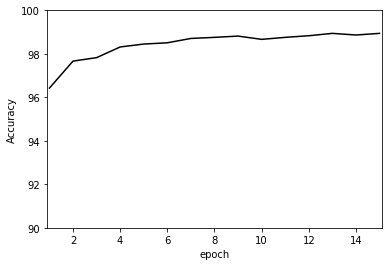

In [8]:
plt.plot(np.arange(1,len(list_accuracy)+1), list_accuracy, 'k')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.axis([0.9,len(list_accuracy)+0.1,90,100]);